## NLP Class Assignment 5

### Import Libraries

In [1]:
import pandas as pd

# pandas settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [12]:
import pandas as pd
import nltk as nltk
import nltk.corpus  
from nltk.text import Text
import re
import sys
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
from itertools import combinations
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk import ngrams
from spacy.lang.en.stop_words import STOP_WORDS
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pandarallel import pandarallel
import multiprocessing
# Initialize pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [118]:
from pandarallel import pandarallel
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(f"You have {num_cores} cores.")# Initialize pandarallel to use num_cores - 1
pandarallel.initialize(nb_workers=num_cores-1)

You have 10 cores.
INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


#### Read news data

In [20]:
news_path = 'https://storage.googleapis.com/msca-bdp-data-open/news/nlp_a_5_news.json'
news_df = pd.read_json(news_path, orient='records', lines=True)

print(f'Sample contains {news_df.shape[0]:,.0f} news articles')
news_df.head(2)

Sample contains 10,012 news articles


,url,date,language,title,text
0,http://kokomoperspective.com/obituaries/jon-w-horton/article_b6ba8e1e-cb9c-11eb-9868-fb11b88b9778.html,2021-06-13,en,Jon W. Horton | Obituaries | kokomoperspective.com,Jon W. Horton | Obituaries | kokomoperspective.comYou have permission to edit this article. EditCloseSign Up Log In Dashboard LogoutMy Account Dashboard Profile Saved items LogoutCOVID-19Click here for the latest local news on COVID-19HomeAbout UsContact UsNewsLocalOpinionPoliticsNationalStateAgricultureLifestylesEngagements/Anniversaries/WeddingsAutosEntertainmentHealthHomesOutdoorsSportsNFLNCAAVitalsObituariesAutomotivee-EditionCouponsGalleries74°...
1,https://auto.economictimes.indiatimes.com/news/auto-components/birla-precision-to-ramp-up-capacity-to-tap-emerging-opportunities-in-india/81254902,2021-02-28,en,"Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto","Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto We have updated our terms and conditions and privacy policy Click ""Continue"" to accept and continue with ET AutoAccept the updated privacy & cookie policyDear user, ET Auto privacy and cookie policy has been updated to align with the new data regulations in European Union. Please review and accept these changes below to continue using the website.You can see our privacy policy & our cookie ..."


#### Read Tweets data

In [3]:
tweets_path = 'https://storage.googleapis.com/msca-bdp-data-open/tweets/nlp_a_5_tweets.json'
tweets_df = pd.read_json(tweets_path, orient='records', lines=True)
print(f'Sample contains {tweets_df.shape[0]:,.0f} tweets')
tweets_df.head(2)

Sample contains 10,105 tweets


,id,lang,date,name,retweeted,text
0,1534565117614084096,en,2022-06-08,Low Orbit Tourist 🌍📷,,"Body &amp; Assembly - Halewood - United Kingdom\n🌍53.3504,-2.8352296,402m\n\nHalewood Body &amp; Assembly is a Jaguar Land Rover factory in Halewood, England, and forms the major part of the Halewood complex which is shared with Ford who manufacture transmissions at the site. [Wikipedia] https://t.co/LPmCnZIaVt"
1,1534565743429394439,en,2022-06-08,CompleteCar.ie,RT,"Land Rover Ireland has announced that the new Range Rover Sport starts at €114,150, now on @completecar:\n\nhttps://t.co/TjGUkL3FYr https://t.co/QdVaEiJkjO"


In [4]:
import spacy
from collections import Counter

In [5]:
# loading particular nlp model
nlp = spacy.load("en_core_web_md")

type(nlp)

spacy.lang.en.English

# Data Cleaning

We remove URLs, mentions, hashtags, and newline characters for analysis purpose as we did before.
Moreoever, we also convert words that are entirely in uppercase to lowercase, because we saw some netcitizens used uppercase words to emphasize their emtions and feeling, eg. they use "SHAMELESS" to express their disappointment. We think converting words that are entirely in uppercase to lowercase could avoid the model treating these words as proper nouns.

In [6]:
import re
import spacy
import wordninja

def lowercase_if_uppercase(match):
    # Convert matched word to lowercase
    word = match.group(0)
    return word.lower()


def clean_text(text):
    # Remove emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U00002700-\U000027BF"  # Dingbats
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    
    # Remove mentions
    text = re.sub(r'@\w+', ' ', text)
    
    # Remove entire hashtags (both symbol and text)
    text = re.sub(r'#\w+', ' ', text)
    
    # Remove newline characters
    text = text.replace('\n', ' ')
    
    # Convert words that are entirely in uppercase to lowercase
    # This step should come before removing all-uppercase words to ensure
    # meaningful uppercase words are preserved in lowercase
    text = re.sub(r'\b[A-Z]{2,}\b', lowercase_if_uppercase, text)
    
    # Lemmatization
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    
    return lemmatized_text.strip()

# Example usage
text = "team awarded new Land Rover in Louisville | News | wdrb.com   Skip to main contentYou have permission to edit this article. EditClose"
cleaned_text = clean_text(text)
print(cleaned_text)

team award new Land Rover in Louisville | News | wdrb.com    Skip to main contentyou have permission to edit this article . EditClose


In [13]:
tweets_df['cleaned text'] = tweets_df['text'].parallel_apply(clean_text)

In [21]:
news_df['cleaned text'] = news_df['text'].parallel_apply(clean_text)

In [22]:
news_df['cleaned title'] = news_df['title'].parallel_apply(clean_text)

## Extract entities without sentence segmentation for Tweets 

### Efficient Batch Processing with .pipe()

In [14]:
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

In [96]:
# Use pandarallel for parallel apply
tweets_df['entities'] = tweets_df['cleaned text'].parallel_apply(extract_entities)

In [16]:
tweets_df.head(50)

,id,lang,date,name,retweeted,text,cleaned text,entities
0,1534565117614084096,en,2022-06-08,Low Orbit Tourist 🌍📷,,"Body &amp; Assembly - Halewood - United Kingdom\n🌍53.3504,-2.8352296,402m\n\nHalewood Body &amp; Assembly is a Jaguar Land Rover factory in Halewood, England, and forms the major part of the Halewood complex which is shared with Ford who manufacture transmissions at the site. [Wikipedia] https://t.co/LPmCnZIaVt","body & amp ; Assembly - Halewood - United Kingdom 53.3504,-2.8352296,402 m Halewood Body & amp ; Assembly be a Jaguar Land Rover factory in Halewood , England , and form the major part of the Halewood complex which be share with Ford who manufacture transmission at the site . [ wikipedia ]","[(body & amp, ORG), (Assembly - Halewood - United Kingdom, ORG), (53.3504,-2.8352296,402 m, QUANTITY), (Halewood Body & amp, ORG), (Assembly, ORG), (Jaguar Land Rover, ORG), (Halewood, GPE), (England, GPE), (Halewood, GPE), (Ford, ORG)]"
1,1534565743429394439,en,2022-06-08,CompleteCar.ie,RT,"Land Rover Ireland has announced that the new Range Rover Sport starts at €114,150, now on @completecar:\n\nhttps://t.co/TjGUkL3FYr https://t.co/QdVaEiJkjO","Land Rover Ireland have announce that the new Range Rover Sport start at € 114,150 , now on :","[(Land Rover Ireland, ORG), (Range Rover Sport, ORG), (114,150, MONEY)]"
2,1529341557580652545,en,2022-05-25,Exmoor Trim,,New Land Rover Range Rover Hits Top Speed With Ease On Autobahn\n\nhttps://t.co/19QOgAIu3v,New Land Rover Range Rover Hits Top Speed with ease on Autobahn,"[(New Land Rover Range Rover Hits Top Speed, ORG), (Autobahn, FAC)]"
3,1542790343535755264,en,2022-07-01,Land Rover UK,,"@BeckyWatts1 Hi, thank you for your post. I am sorry to learn of your retailer experience, however when order slots are available they will be presented to the retailer, and it is at their discretion which vehicles they submit. Please continue to liaise with them. Thanks, Dan - Land Rover UK","hi , thank you for your post . I be sorry to learn of your retailer experience , however when order slot be available they will be present to the retailer , and it be at their discretion which vehicle they submit . please continue to liaise with they . thank , Dan - Land Rover uk","[(Dan - Land, PERSON)]"
4,1516732103370493954,en,2022-04-20,Sussexes❤️👑🐼🌸,,@cofvefe917 @Mackingday No this was during the Land Rover driving challenge.,no this be during the Land Rover drive challenge .,"[(Land Rover, ORG)]"
5,1526492942512312320,en,2022-05-17,Mat Rees,RT,"Just watched this Land Rover toss piles of rubbish - balloons, empty alcohol bottles, empty takeaway containers - out the window on Brunswick Sq in broad daylight and then drive off.\n\nFeel free to give Mainstream Property Services a call and online review! https://t.co/O2Tvu64wB0","just watch this Land Rover toss pile of rubbish - balloon , empty alcohol bottle , empty takeaway container - out the window on Brunswick Sq in broad daylight and then drive off . feel free to give Mainstream Property Services a call and online review !","[(Land Rover, PRODUCT), (Brunswick Sq, FAC), (Mainstream Property Services, ORG)]"
6,1526493037806878720,en,2022-05-17,Baron Woke of Carlsberg 🇺🇦,RT,"Just watched this Land Rover toss piles of rubbish - balloons, empty alcohol bottles, empty takeaway containers - out the window on Brunswick Sq in broad daylight and then drive off.\n\nFeel free to give Mainstream Property Services a call and online review! https://t.co/O2Tvu64wB0","just watch this Land Rover toss pile of rubbish - balloon , empty alcohol bottle , empty takeaway container - out the window on Brunswick Sq in broad daylight and then drive off . feel free to give Mainstream Property Services a call and online review !","[(Land Rover, PRODUCT), (Brunswick Sq, FAC), (Mainstream Property Services, ORG)]"
7,1552029227146530817,en,2022-07-26,Ngwati Francis,RT,'Parts are not available'\n\n'Nissans are not good cars'\n\n'Mazda diesels are problematic'\n\n'Usinunue Land 

In [17]:
# Flatten the list of entities and extract only the entity types
entity_types = [entity_type for sublist in tweets_df['entities'] for _, entity_type in sublist]

# Calculate the distribution of entity types
entity_distribution = Counter(entity_types)

print(entity_distribution)

Counter({'ORG': 13724, 'DATE': 3535, 'PERSON': 3422, 'CARDINAL': 3409, 'PRODUCT': 3094, 'GPE': 2568, 'MONEY': 1175, 'NORP': 638, 'ORDINAL': 528, 'QUANTITY': 461, 'TIME': 316, 'FAC': 289, 'LOC': 181, 'WORK_OF_ART': 171, 'EVENT': 149, 'PERCENT': 125, 'LAW': 49, 'LANGUAGE': 7})


In [186]:
# Flatten the entities list, filter by "ORG", and count occurrences
org_entities = [entity for sublist in tweets_df['entities'] for entity in sublist if entity[1] == 'ORG']
org_text_counts = Counter([entity[0] for entity in org_entities])

# Get the top 20 most common "ORG" entities
top_20_org_entities = org_text_counts.most_common(20)

print(top_20_org_entities)

[('Land Rover', 2265), ('Jaguar Land Rover', 1194), ('eBay', 471), ('Land Rover Defender', 400), ('bmw', 391), ('Audi', 338), ('Mercedes - Benz', 311), ('Citroen', 292), ('General Motors', 291), ('Jaguar', 213), ('Ford', 126), ('Tesla', 115), ('Bentley', 106), ('Volvo', 97), ('Land Rover Range', 87), ('Jeep', 86), ('Health Services Board', 82), ('the Land Rover Defender', 75), ('Land Rover Range Rover', 69), ('Rover', 69)]


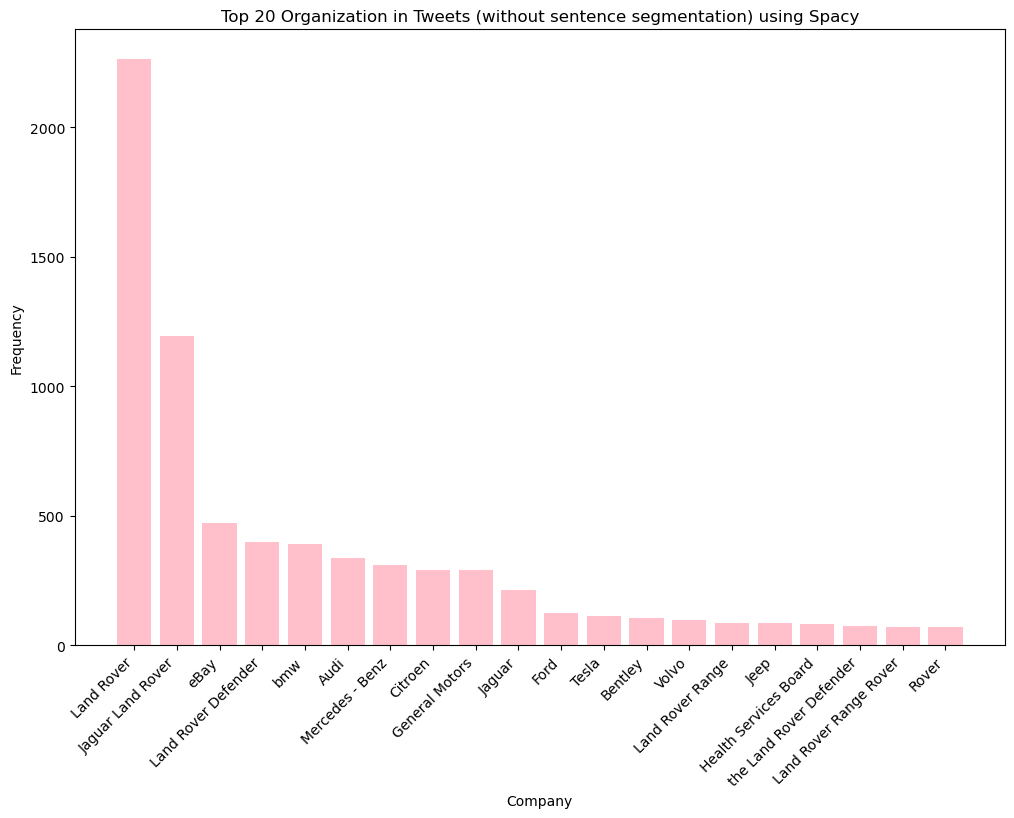

In [187]:
# Assuming top_20_org_cleaned_entities is correctly filled with your data
entity_names, counts = zip(*top_20_org_entities)
# Set the figure size for better readability
plt.figure(figsize=(12, 8))  # Adjusted for vertical orientation
# Create a vertical bar chart
plt.bar(entity_names, counts, color="pink")
# Y-axis label now represents frequency
plt.ylabel('Frequency')
# X-axis label now represents company names
plt.xlabel('Company')
# Title of the plot
plt.title('Top 20 Organization in Tweets (without sentence segmentation) using Spacy')
# Rotate company names for better readability
plt.xticks(rotation=45, ha="right")
# Dislay the plot
plt.show()


## Extract entities without sentence segmentation for News

In [23]:
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

In [24]:
news_df['entities'] = news_df['cleaned text'].parallel_apply(extract_entities)

In [35]:
news_df.head()

,url,date,language,title,text,cleaned text,cleaned title,entities
0,http://kokomoperspective.com/obituaries/jon-w-horton/article_b6ba8e1e-cb9c-11eb-9868-fb11b88b9778.html,2021-06-13,en,Jon W. Horton | Obituaries | kokomoperspective.com,Jon W. Horton | Obituaries | kokomoperspective.comYou have permission to edit this article. EditCloseSign Up Log In Dashboard LogoutMy Account Dashboard Profile Saved items LogoutCOVID-19Click here for the latest local news on COVID-19HomeAbout UsContact UsNewsLocalOpinionPoliticsNationalStateAgricultureLifestylesEngagements/Anniversaries/WeddingsAutosEntertainmentHealthHomesOutdoorsSportsNFLNCAAVitalsObituariesAutomotivee-EditionCouponsGalleries74°...,Jon W. Horton | Obituaries | kokomoperspective.comyou have permission to edit this article . editclosesign up log in Dashboard LogoutMy Account Dashboard Profile Saved item LogoutCOVID-19Click here for the late local news on covid-19HomeAbout UsContact usnewslocalopinionpoliticsnationalstateagriculturelifestylesengagement / Anniversaries / WeddingsAutosEntertainmentHealthHomesOutdoorsSportsNFLNCAAVitalsObituariesAutomotivee - EditionCouponsGaller...,Jon W. Horton | Obituaries | kokomoperspective.com,"[(Jon W. Horton | Obituaries |, PERSON), (Dashboard , WORK_OF_ART), (LogoutMy Account Dashboard Profile Saved, ORG), (LogoutCOVID-19Click, ORG), (covid-19HomeAbout UsContact, ORG), (Kokomo, GPE), (46901)todaya, FAC), (67F., CARDINAL), (67F., CARDINAL), (June 12 , 2021, DATE), (10:31 pm, TIME), (ForecastFacebookTwitterToggle, PERSON), (covid-19, ORG), (HomeAbout UsContact, PERSON), (Jon W. Horton, PERSON), (Jun 12 , 2021 , DATE), (W. Horton, PERSON), (72, CARDINAL), (Tipton, ORG), (..."
1,https://auto.economictimes.indiatimes.com/news/auto-components/birla-precision-to-ramp-up-capacity-to-tap-emerging-opportunities-in-india/81254902,2021-02-28,en,"Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto","Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto We have updated our terms and conditions and privacy policy Click ""Continue"" to accept and continue with ET AutoAccept the updated privacy & cookie policyDear user, ET Auto privacy and cookie policy has been updated to align with the new data regulations in European Union. Please review and accept these changes below to continue using the website.You can see our privacy policy & our cookie ...","Birla Precision to ramp up capacity to tap emerge opportunity in India , Auto News , et Auto we have update our term and condition and privacy policy Click "" Continue "" to accept and continue with et AutoAccept the update privacy & cookie policydear user , et Auto privacy and cookie policy have be update to align with the new datum regulation in European Union . please review and accept these change below to continue use the website . you can see our privacy policy & our cookie policy ....","Birla Precision to ramp up capacity to tap emerge opportunity in India , Auto News , et Auto","[(Birla Precision, PERSON), (India, GPE), (Auto News, ORG), (et AutoAccept, ORG), (European Union, ORG), (AnalyticsNecessaryNewsletter NameProviderExpiryTypePurpose, PERSON), (Google, ORG), (YearHTTPSTo, PERSON), (AnalyticsIbeat1, CARDINAL), (optouttime Internet1 YearHTTPSStores, ORG), (dayhttpsstore user 's, ORG), (yearhttpsuniquely, PERSON), (NamePurpose, ORG), (daily, DATE), (mailersreceive, GPE), (Retail News Health News Telecom News Energy News, ORG), (Security News, ORG), (News ..."
2,https://ca.sports.yahoo.com/news/global-hydrogen-fueling-station-markets-104800330.html?src=rss,2021-12-07,en,Global Hydrogen Fueling Station Markets to 2035: Current State and Future Prognosis of Passenger Hydrogen Fuel Cell Vehicles (FCVs),Global Hydrogen Fueling Station Markets to 2035: Current State and Future Prognosis of Passenger Hydrogen Fuel Cell Vehicles (FCVs) HOME MAIL NEWS SPORTS FINANCE CELEBRITY STYLE MOVIES WEATHER MOBILE Yahoo Sports Sign in 

In [184]:
# Flatten the entities list, filter by "ORG", and count occurrences
org_entities = [entity for sublist in news_df['entities'] for entity in sublist if entity[1] == 'ORG']
org_text_counts = Counter([entity[0] for entity in org_entities])

# Get the top 20 most common "ORG" entities
top_20_org_entities = org_text_counts.most_common(20)

print(top_20_org_entities)

[('Facebook', 9242), ('Ford', 7607), ('Netflix', 7179), ('Toyota', 6099), ('covid-19', 4511), ('Hyundai', 4350), ('Amazon', 4060), ('Honda', 3990), ('Land Rover', 3464), ('Instagram', 3213), ('Chevrolet', 3020), ("Prince Philip 's", 2969), ('bmw', 2930), ('Tesla', 2879), ('Nissan', 2707), ('Apple', 2609), ('Royal', 2380), ('the Daily Mail', 2121), ('Crown', 2097), ('House', 2050)]


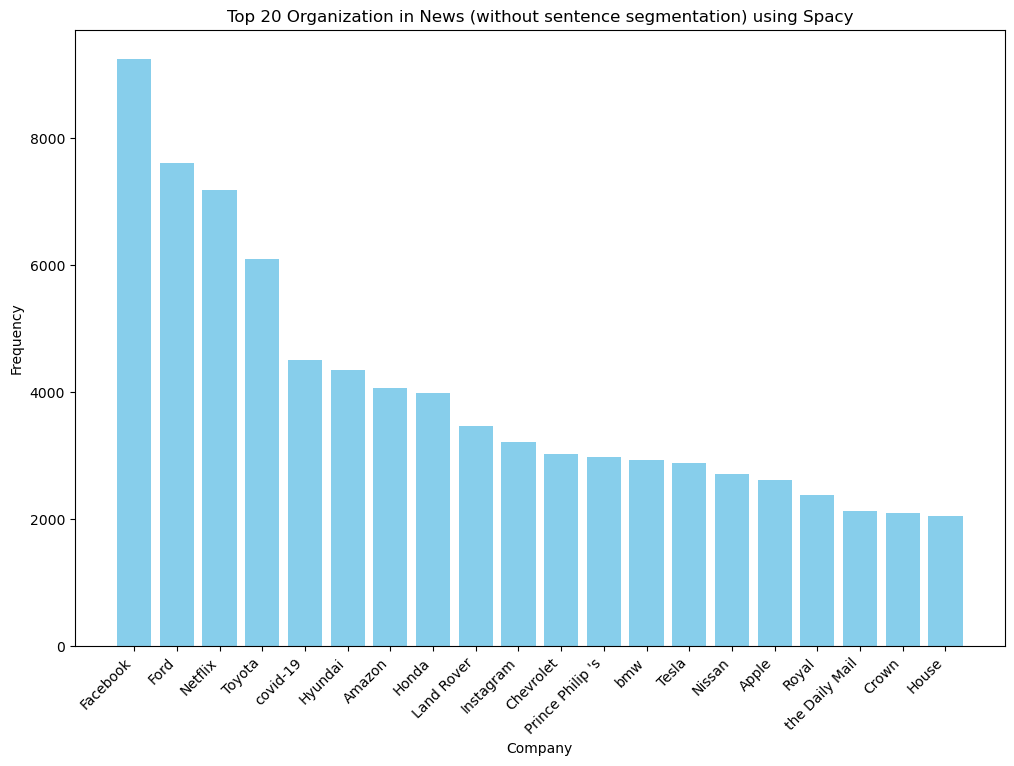

In [185]:
entity_names, counts = zip(*top_20_org_entities)
plt.figure(figsize=(12, 8))  # Adjusted for vertical orientation
plt.bar(entity_names, counts, color="skyblue")
plt.ylabel('Frequency')
plt.xlabel('Company')
plt.title('Top 20 Organization in News (without sentence segmentation) using Spacy')
plt.xticks(rotation=45, ha="right")
plt.show()

## For News' title

In [46]:
news_df.head(2)

,url,date,language,title,text,cleaned text,cleaned title,entities,title entities
0,http://kokomoperspective.com/obituaries/jon-w-horton/article_b6ba8e1e-cb9c-11eb-9868-fb11b88b9778.html,2021-06-13,en,Jon W. Horton | Obituaries | kokomoperspective.com,Jon W. Horton | Obituaries | kokomoperspective.comYou have permission to edit this article. EditCloseSign Up Log In Dashboard LogoutMy Account Dashboard Profile Saved items LogoutCOVID-19Click here for the latest local news on COVID-19HomeAbout UsContact UsNewsLocalOpinionPoliticsNationalStateAgricultureLifestylesEngagements/Anniversaries/WeddingsAutosEntertainmentHealthHomesOutdoorsSportsNFLNCAAVitalsObituariesAutomotivee-EditionCouponsGalleries74°...,Jon W. Horton | Obituaries | kokomoperspective.comyou have permission to edit this article . editclosesign up log in Dashboard LogoutMy Account Dashboard Profile Saved item LogoutCOVID-19Click here for the late local news on covid-19HomeAbout UsContact usnewslocalopinionpoliticsnationalstateagriculturelifestylesengagement / Anniversaries / WeddingsAutosEntertainmentHealthHomesOutdoorsSportsNFLNCAAVitalsObituariesAutomotivee - EditionCouponsGaller...,Jon W. Horton | Obituaries | kokomoperspective.com,"[(Jon W. Horton | Obituaries |, PERSON), (Dashboard , WORK_OF_ART), (LogoutMy Account Dashboard Profile Saved, ORG), (LogoutCOVID-19Click, ORG), (covid-19HomeAbout UsContact, ORG), (Kokomo, GPE), (46901)todaya, FAC), (67F., CARDINAL), (67F., CARDINAL), (June 12 , 2021, DATE), (10:31 pm, TIME), (ForecastFacebookTwitterToggle, PERSON), (covid-19, ORG), (HomeAbout UsContact, PERSON), (Jon W. Horton, PERSON), (Jun 12 , 2021 , DATE), (W. Horton, PERSON), (72, CARDINAL), (Tipton, ORG), (...","[(Jon, PERSON), (Horton, PERSON)]"
1,https://auto.economictimes.indiatimes.com/news/auto-components/birla-precision-to-ramp-up-capacity-to-tap-emerging-opportunities-in-india/81254902,2021-02-28,en,"Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto","Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto We have updated our terms and conditions and privacy policy Click ""Continue"" to accept and continue with ET AutoAccept the updated privacy & cookie policyDear user, ET Auto privacy and cookie policy has been updated to align with the new data regulations in European Union. Please review and accept these changes below to continue using the website.You can see our privacy policy & our cookie ...","Birla Precision to ramp up capacity to tap emerge opportunity in India , Auto News , et Auto we have update our term and condition and privacy policy Click "" Continue "" to accept and continue with et AutoAccept the update privacy & cookie policydear user , et Auto privacy and cookie policy have be update to align with the new datum regulation in European Union . please review and accept these change below to continue use the website . you can see our privacy policy & our cookie policy ....","Birla Precision to ramp up capacity to tap emerge opportunity in India , Auto News , et Auto","[(Birla Precision, PERSON), (India, GPE), (Auto News, ORG), (et AutoAccept, ORG), (European Union, ORG), (AnalyticsNecessaryNewsletter NameProviderExpiryTypePurpose, PERSON), (Google, ORG), (YearHTTPSTo, PERSON), (AnalyticsIbeat1, CARDINAL), (optouttime Internet1 YearHTTPSStores, ORG), (dayhttpsstore user 's, ORG), (yearhttpsuniquely, PERSON), (NamePurpose, ORG), (daily, DATE), (mailersreceive, GPE), (Retail News Health News Telecom News Energy News, ORG), (Security News, ORG), (News ...","[(Birla, PERSON), (India, GPE), (Auto News, PERSON)]"


In [47]:
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

In [182]:
# Flatten the entities list, filter by "ORG", and count occurrences
org_entities = [entity for sublist in news_df['title entities'] for entity in sublist if entity[1] == 'ORG']
org_text_counts = Counter([entity[0] for entity in org_entities])

# Get the top 20 most common "ORG" entities
top_20_org_entities = org_text_counts.most_common(20)

print(top_20_org_entities)

[('| Daily Mail', 851), ('Ford', 359), ('Ontario | carpages.ca', 308), ('Toyota', 203), ('British Columbia |', 198), ('Chevrolet', 197), ('Hyundai', 177), ('Honda', 162), ('| Star News', 128), ('Alberta | Carpages.ca', 114), ('Nissan', 102), ('bmw', 91), ('| Express & Star', 90), ('Auto News', 72), ('| Otago Daily Times Online News', 67), ('Tesla', 63), ('Saskatchewan | Carpages.ca', 63), ('Jeep', 60), ('Volkswagen', 59), ('Jaguar', 58)]


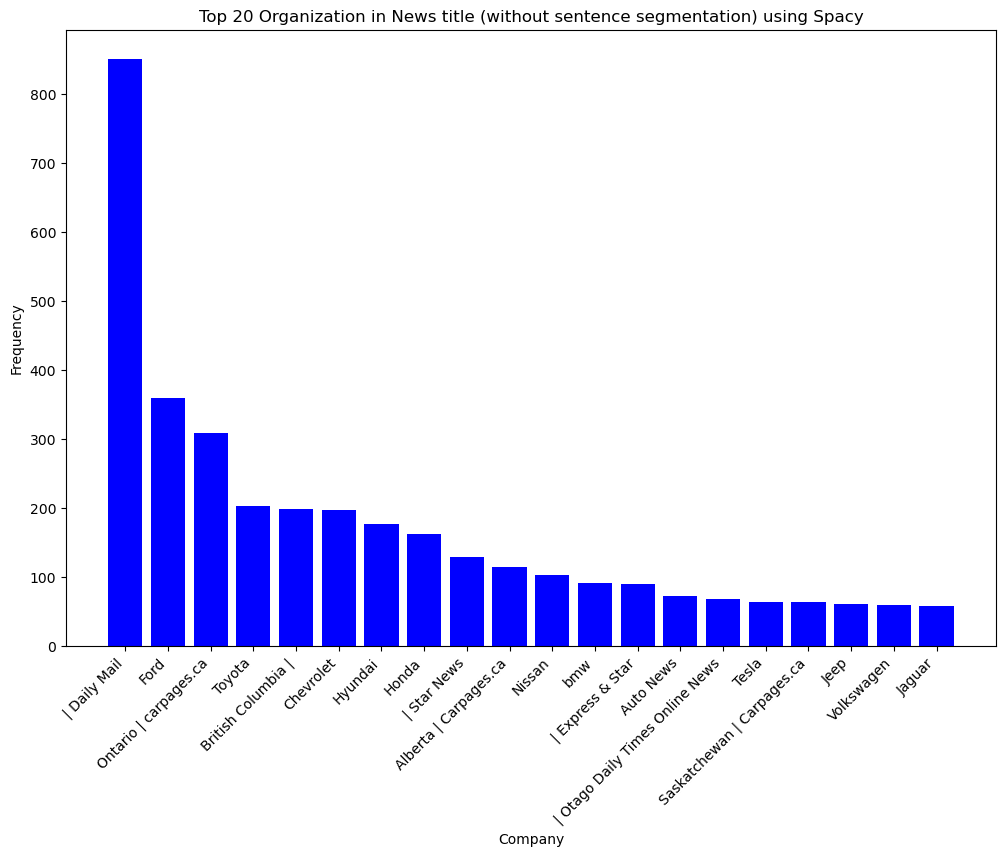

In [183]:
entity_names, counts = zip(*top_20_org_entities)
plt.figure(figsize=(12, 8))  # Adjusted for vertical orientation
plt.bar(entity_names, counts, color="blue")
plt.ylabel('Frequency')
plt.xlabel('Company')
plt.title('Top 20 Organization in News title (without sentence segmentation) using Spacy')
plt.xticks(rotation=45, ha="right")
plt.show()

# Extract entities with sentence segmentation for Tweets

In [68]:
def segment_sentences(text):
    doc = nlp(text)
    return [sentence.text.strip() for sentence in doc.sents]

In [53]:
tweets_df['segmented sentences'] = tweets_df['cleaned text'].parallel_apply(segment_sentences)

In [54]:
tweets_df.head()

,id,lang,date,name,retweeted,text,cleaned text,entities,NLTK_entities,NLTK_seg_entities,segmented sentences
0,1534565117614084096,en,2022-06-08,Low Orbit Tourist 🌍📷,,"Body &amp; Assembly - Halewood - United Kingdom\n🌍53.3504,-2.8352296,402m\n\nHalewood Body &amp; Assembly is a Jaguar Land Rover factory in Halewood, England, and forms the major part of the Halewood complex which is shared with Ford who manufacture transmissions at the site. [Wikipedia] https://t.co/LPmCnZIaVt","body & amp ; Assembly - Halewood - United Kingdom 53.3504,-2.8352296,402 m Halewood Body & amp ; Assembly be a Jaguar Land Rover factory in Halewood , England , and form the major part of the Halewood complex which be share with Ford who manufacture transmission at the site . [ wikipedia ]","[(body & amp, ORG), (Assembly - Halewood - United Kingdom, ORG), (53.3504,-2.8352296,402 m, QUANTITY), (Halewood Body & amp, ORG), (Assembly, ORG), (Jaguar Land Rover, ORG), (Halewood, GPE), (England, GPE), (Halewood, GPE), (Ford, ORG)]","[(Assembly, ORGANIZATION), (Halewood, GPE), (United, GPE), (Halewood Body, PERSON), (Jaguar Land, ORGANIZATION), (Halewood, GPE), (England, GPE), (Halewood, ORGANIZATION)]","[(Assembly, ORGANIZATION), (Halewood, GPE), (United, GPE), (Halewood Body, PERSON), (Jaguar Land, ORGANIZATION), (Halewood, GPE), (England, GPE), (Halewood, ORGANIZATION)]","[body & amp ; Assembly - Halewood - United Kingdom 53.3504,-2.8352296,402 m Halewood Body & amp ; Assembly be a Jaguar Land Rover factory in Halewood , England , and form the major part of the Halewood complex which be share with Ford who manufacture transmission at the site ., [ wikipedia ]]"
1,1534565743429394439,en,2022-06-08,CompleteCar.ie,RT,"Land Rover Ireland has announced that the new Range Rover Sport starts at €114,150, now on @completecar:\n\nhttps://t.co/TjGUkL3FYr https://t.co/QdVaEiJkjO","Land Rover Ireland have announce that the new Range Rover Sport start at € 114,150 , now on :","[(Land Rover Ireland, ORG), (Range Rover Sport, ORG), (114,150, MONEY)]","[(Land, GPE), (Rover Ireland, PERSON), (Range Rover Sport, PERSON)]","[(Land, GPE), (Rover Ireland, PERSON), (Range Rover Sport, PERSON)]","[Land Rover Ireland have announce that the new Range Rover Sport start at € 114,150 , now on :]"
2,1529341557580652545,en,2022-05-25,Exmoor Trim,,New Land Rover Range Rover Hits Top Speed With Ease On Autobahn\n\nhttps://t.co/19QOgAIu3v,New Land Rover Range Rover Hits Top Speed with ease on Autobahn,"[(New Land Rover Range Rover Hits Top Speed, ORG), (Autobahn, FAC)]","[(New Land, GPE), (Range Rover Hits Top Speed, PERSON)]","[(New Land, GPE), (Range Rover Hits Top Speed, PERSON)]",[New Land Rover Range Rover Hits Top Speed with ease on Autobahn]
3,1542790343535755264,en,2022-07-01,Land Rover UK,,"@BeckyWatts1 Hi, thank you for your post. I am sorry to learn of your retailer experience, however when order slots are available they will be presented to the retailer, and it is at their discretion which vehicles they submit. Please continue to liaise with them. Thanks, Dan - Land Rover UK","hi , thank you for your post . I be sorry to learn of your retailer experience , however when order slot be available they will be present to the retailer , and it be at their discretion which vehicle they submit . please continue to liaise with they . thank , Dan - Land Rover uk","[(Dan - Land, PERSON)]","[(Dan, GPE), (Land, GPE)]","[(Dan, GPE), (Land, GPE)]","[hi , thank you for your post ., I be sorry to learn of your retailer experience , however when order slot be available they will be present to the retailer , and it be at their discretion which vehicle they submit ., please continue to liaise with they ., thank , Dan - Land Rover uk]"
4,1516732103370493954,en,2022-04-20,Sussexes❤️👑🐼🌸,,@cofvefe917 @Mackingday No this was during the Land Rover driving challenge.,no this be during the Land Rover drive challenge .,"[(Land Rover, ORG)]","[(Land Rover, ORGANIZATION)]","[(Land Rover, ORGANIZATION)]",[no th

In [63]:
def extract_entities_pipe(texts, batch_size=500):
    entities_batch = []
    for doc in nlp.pipe(texts, batch_size=batch_size):
        doc_entities = [(ent.text, ent.label_) for ent in doc.ents]
        entities_batch.append(doc_entities)
    return entities_batch

# Flatten the list of lists into a single list of sentences
flat_list_of_sentences = [sentence for sublist in tweets_df['segmented sentences'] for sentence in sublist]

# Now flat_list_of_sentences is a flat list of strings, as expected
entities_batch = extract_entities_pipe(flat_list_of_sentences)
# This is an illustrative example; actual implementation might vary
# Assume entities_batch is now a list of lists of entities for each sentence
# And we want to associate them back with the original DataFrame's rows

# Initialize an empty list to store entities grouped by original tweets
grouped_entities = []
index = 0

# Iterate over the original list of lists
for sublist in tweets_df['segmented sentences']:
    # For each sublist, aggregate entities from the corresponding number of sentences
    tweet_entities = []
    for _ in sublist:
        tweet_entities.extend(entities_batch[index])
        index += 1
    grouped_entities.append(tweet_entities)

# Now grouped_entities should align with the rows of tweets_df
tweets_df['segmented entities'] = grouped_entities

In [180]:
# Flatten the entities list, filter by "ORG", and count occurrences
org_seg_entities = [entity for sublist in tweets_df['segmented entities'] for entity in sublist if entity[1] == 'ORG']
org_seg_text_counts = Counter([entity[0] for entity in org_seg_entities])

# Get the top 20 most common "ORG" entities
top_20_org_seg_entities = org_seg_text_counts.most_common(20)

print(top_20_org_seg_entities)

[('Land Rover', 2311), ('Jaguar Land Rover', 1193), ('eBay', 471), ('Land Rover Defender', 408), ('bmw', 393), ('Audi', 339), ('Mercedes - Benz', 311), ('Citroen', 292), ('General Motors', 291), ('Jaguar', 213), ('Ford', 126), ('Tesla', 115), ('Bentley', 112), ('Volvo', 98), ('Jeep', 87), ('Land Rover Range', 83), ('Health Services Board', 82), ('the Land Rover Defender', 76), ('Land Rover Range Rover', 73), ('Range Rover', 69)]


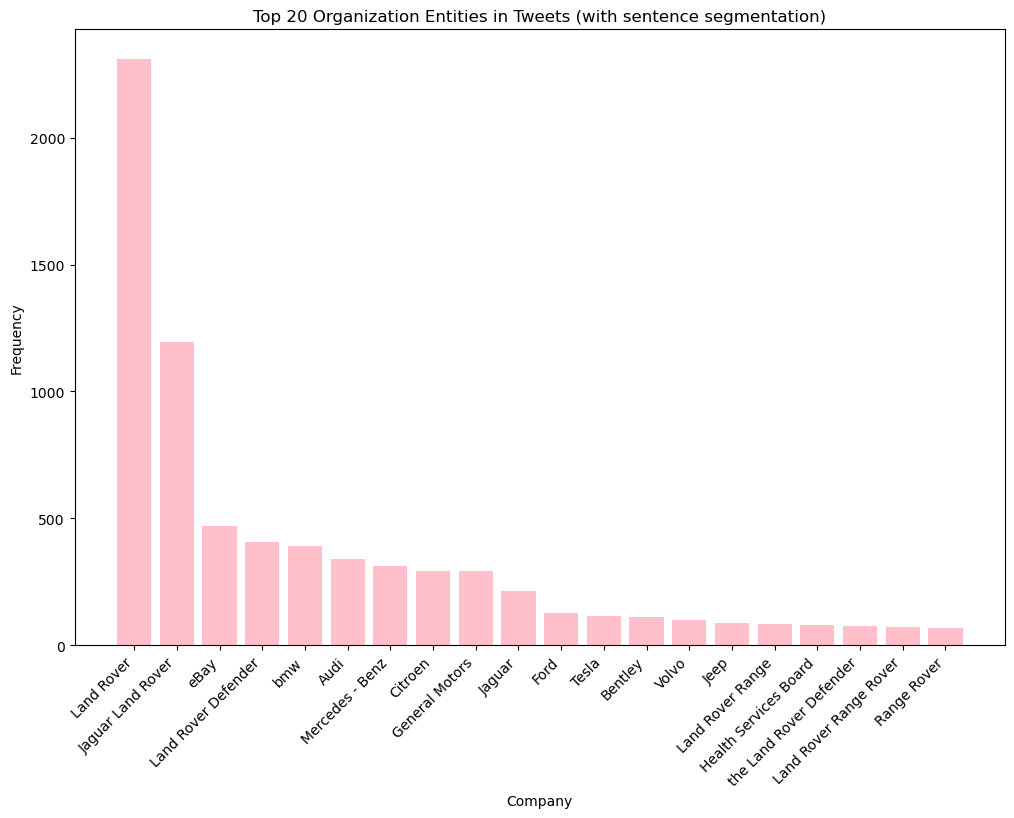

In [181]:
# Assuming entity_names and counts have been defined as before
entity_names, counts = zip(*top_20_org_seg_entities)  # Unzipping names and counts

plt.figure(figsize=(12, 8))  # Adjust figure size as needed for vertical orientation
plt.bar(entity_names, counts, color="pink")  # Create a vertical bar chart
plt.ylabel('Frequency')  # Y-axis label now represents frequency
plt.xlabel('Company')  # X-axis label now represents company names
plt.title('Top 20 Organization Entities in Tweets (with sentence segmentation)')  # Title of the plot
plt.xticks(rotation=45, ha="right")  # Rotate company names for better readability
plt.show()

## Plot above is our final result. We found analysis on Tweets data using Spacy and sentences segmentation is our best solution to find out most relevent company names. We also found that there's no significant difference between output obtained from sentences segmentation and without  sentences segmentation.

# Extract entities with sentence segmentation for News

In [70]:
def segment_sentences(text):
    doc = nlp(text)
    return [sentence.text.strip() for sentence in doc.sents]

In [71]:
news_df['segmented sentences'] = news_df['cleaned text'].parallel_apply(segment_sentences)

In [150]:
def extract_entities_pipe(texts, batch_size=500):
    entities_batch = []
    for doc in nlp.pipe(texts, batch_size=batch_size):
        doc_entities = [(ent.text, ent.label_) for ent in doc.ents]
        entities_batch.append(doc_entities)
    return entities_batch

# Flatten the list of lists into a single list of sentences
flat_list_of_sentences = [sentence for sublist in news_df['segmented sentences'] for sentence in sublist]

# Now flat_list_of_sentences is a flat list of strings, as expected
entities_batch = extract_entities_pipe(flat_list_of_sentences)
# This is an illustrative example; actual implementation might vary
# Assume entities_batch is now a list of lists of entities for each sentence
# And we want to associate them back with the original DataFrame's rows

# Initialize an empty list to store entities grouped by original tweets
grouped_entities = []
index = 0

# Iterate over the original list of lists
for sublist in news_df['segmented sentences']:
    # For each sublist, aggregate entities from the corresponding number of sentences
    news_df_entities = []
    for _ in sublist:
        news_df_entities.extend(entities_batch[index])
        index += 1
    grouped_entities.append(news_df_entities)

# Now grouped_entities should align with the rows of tweets_df
news_df['segmented entities'] = grouped_entities

In [178]:
# Flatten the entities list, filter by "ORG", and count occurrences
org_seg_entities = [entity for sublist in news_df['segmented entities'] for entity in sublist if entity[1] == 'ORG']
org_seg_text_counts = Counter([entity[0] for entity in org_seg_entities])

# Get the top 20 most common "ORG" entities
top_20_org_seg_entities = org_seg_text_counts.most_common(20)

print(top_20_org_seg_entities)

[('Facebook', 9236), ('Ford', 7458), ('Netflix', 7188), ('Toyota', 6143), ('covid-19', 4512), ('Hyundai', 4346), ('Amazon', 4064), ('Honda', 3996), ("Prince Philip 's", 3528), ('Land Rover', 3444), ('Instagram', 3381), ('Tesla', 3067), ('Chevrolet', 3037), ('bmw', 2964), ('Nissan', 2760), ('Apple', 2633), ('lacma', 2632), ('Royal', 2379), ('Hailey Bieber', 2193), ('Crown', 2158)]


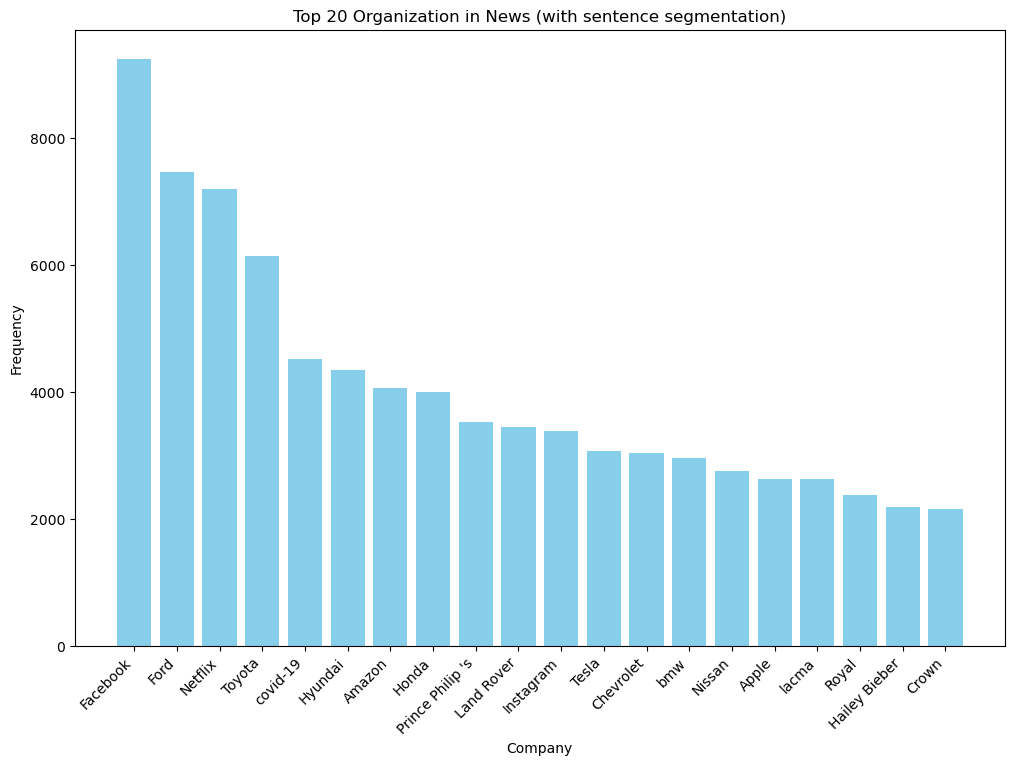

In [179]:
# Assuming entity_names and counts have been defined as before
entity_names, counts = zip(*top_20_org_seg_entities)  # Unzipping names and counts

plt.figure(figsize=(12, 8))  # Adjust figure size as needed for vertical orientation
plt.bar(entity_names, counts, color="skyblue")  # Create a vertical bar chart
plt.ylabel('Frequency')  # Y-axis label now represents frequency
plt.xlabel('Company')  # X-axis label now represents company names
plt.title('Top 20 Organization in News (with sentence segmentation)')  # Title of the plot
plt.xticks(rotation=45, ha="right")  # Rotate company names for better readability
plt.show()

## For News data, even though Land Rover, which we found the most relevent company name in Tweets, is not that dominant as it is in Tweets data, we figured out that Land Rover could also be labeled as "PRODUCT" by Spacy and therefore decreased our analysis accuracy. Based on this consideration, we still prioritize the company name as Land Rover as we found in Tweets data, because we believe tweets data is not large as News data, so it's not complicated to handle it.

# For News' title

In [141]:
news_df['segmented title'] = news_df['cleaned title'].parallel_apply(segment_sentences)

In [153]:
# Flatten the list of lists into a single list of sentences
flat_list_of_sentences = [sentence for sublist in news_df['segmented title'] for sentence in sublist]

# Now flat_list_of_sentences is a flat list of strings, as expected
entities_batch = extract_entities_pipe(flat_list_of_sentences)
# This is an illustrative example; actual implementation might vary
# Assume entities_batch is now a list of lists of entities for each sentence
# And we want to associate them back with the original DataFrame's rows

# Initialize an empty list to store entities grouped by original tweets
grouped_entities = []
index = 0

# Iterate over the original list of lists
for sublist in news_df['segmented title']:
    # For each sublist, aggregate entities from the corresponding number of sentences
    news_entities = []
    for _ in sublist:
        news_entities.extend(entities_batch[index])
        index += 1
    grouped_entities.append(news_entities)

# Now grouped_entities should align with the rows of tweets_df
news_df['segmented title entities'] = grouped_entities

In [176]:
# Flatten the entities list, filter by "ORG", and count occurrences
org_seg_entities = [entity for sublist in news_df['segmented title entities'] for entity in sublist if entity[1] == 'ORG']
org_seg_text_counts = Counter([entity[0] for entity in org_seg_entities])

# Get the top 20 most common "ORG" entities
top_20_org_seg_entities = org_seg_text_counts.most_common(20)

print(top_20_org_seg_entities)

[('| Daily Mail', 866), ('Daily Mail', 446), ('Ford', 359), ('Ontario | carpages.ca', 308), ('Toyota', 204), ('Chevrolet', 197), ('British Columbia |', 195), ('Hyundai', 177), ('Honda', 162), ('| Star News', 131), ('Alberta | Carpages.ca', 114), ('Nissan', 102), ('bmw', 92), ('| Express & Star', 91), ('Auto News', 72), ('| Otago Daily Times Online News', 67), ('Tesla', 63), ('Saskatchewan | Carpages.ca', 63), ('Jeep', 60), ('Jaguar', 59)]


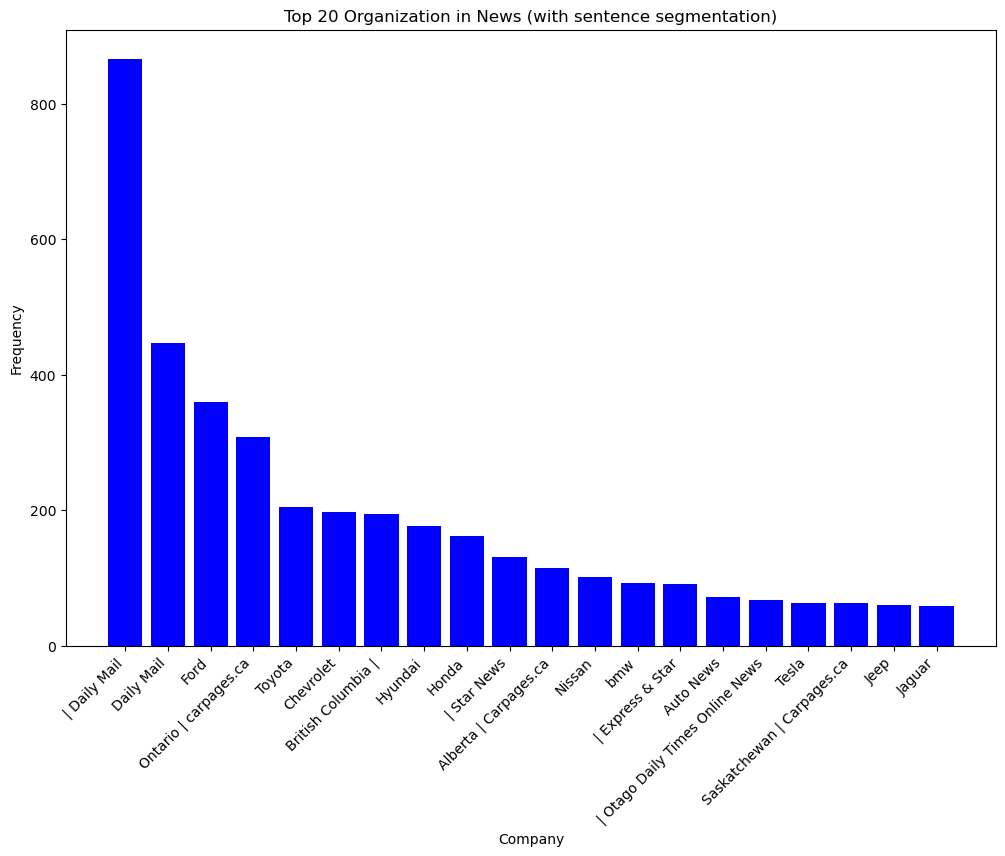

In [177]:
# Assuming entity_names and counts have been defined as before
entity_names, counts = zip(*top_20_org_seg_entities)  # Unzipping names and counts

plt.figure(figsize=(12, 8))  # Adjust figure size as needed for vertical orientation
plt.bar(entity_names, counts, color="blue")  # Create a vertical bar chart
plt.ylabel('Frequency')  # Y-axis label now represents frequency
plt.xlabel('Company')  # X-axis label now represents company names
plt.title('Top 20 Organization in News (with sentence segmentation)')  # Title of the plot
plt.xticks(rotation=45, ha="right")  # Rotate company names for better readability
plt.show()

## We found anaysis on News' title with the same technique could lead to least accuracy as the plot showed above.

# Q2: Identify what other companies are most frequently mentioned along with your primary company

## Our primary company is Land Rover

## In Tweets

In [27]:
from collections import Counter


# Initialize a Counter object to count mentions of other companies
other_companies_counts = Counter()
primary_company = 'Land Rover'
# Iterate through each row in the DataFrame
for entities in tweets_df['entities']:
    # Check if the primary company is mentioned in the current document's entities
    if any(primary_company in entity for entity, label in entities if label == 'ORG'):
        # Filter for other organization entities in this document
        other_companies = [entity for entity, label in entities if label == 'ORG' and primary_company not in entity]
        # Update counts for other companies mentioned in the same document
        other_companies_counts.update(other_companies)

# Get the most common companies mentioned alongside the primary company
most_common_companies = other_companies_counts.most_common(10)

# Display the results
print(f"Companies most frequently mentioned with {primary_company}:")
for company, count in most_common_companies:
    print(f"{company}: {count} times")


Companies most frequently mentioned with Land Rover:
bmw: 346 times
Audi: 329 times
Mercedes - Benz: 299 times
General Motors: 291 times
Citroen: 289 times
Jaguar: 150 times
eBay: 149 times
Tesla: 92 times
Bentley: 90 times
Jeep: 77 times


## In News

In [140]:
from collections import Counter


# Initialize a Counter object to count mentions of other companies
other_companies_counts = Counter()
primary_company = 'Land Rover'
# Iterate through each row in the DataFrame
for entities in news_df['entities']:
    # Check if the primary company is mentioned in the current document's entities
    if any(primary_company in entity for entity, label in entities if label == 'ORG'):
        # Filter for other organization entities in this document
        other_companies = [entity for entity, label in entities if label == 'ORG' and primary_company not in entity]
        # Update counts for other companies mentioned in the same document
        other_companies_counts.update(other_companies)

# Get the most common companies mentioned alongside the primary company
most_common_companies = other_companies_counts.most_common(10)

# Display the results
print(f"Companies most frequently mentioned with {primary_company}:")
for company, count in most_common_companies:
    print(f"{company}: {count} times")

Companies most frequently mentioned with Land Rover:
Facebook: 6692 times
Netflix: 5371 times
Amazon: 2709 times
covid-19: 2544 times
Instagram: 2216 times
Ford: 2193 times
Prince Philip 's: 2132 times
Palace: 1944 times
Apple: 1920 times
Royal: 1723 times


# Q3: Identify most frequent locations of events, by extracting appropriate named entities. Locations may include countries, states, cities, regions, etc.

## Location for Tweets

In [98]:
# Filter out location entities
tweets_location = [entity[0] for row in tweets_df['entities'] for entity in row if entity[1] in ['GPE', 'LOC', 'FAC']]

In [138]:
location_counts = Counter(tweets_location)
most_common_locations = location_counts.most_common(20)
for location, count in most_common_locations:
    print(f"{location}: {count}")

Russia: 183
uk: 150
Zimbabwe: 118
India: 94
Cambridge: 85
BaT: 82
Britain: 65
Jamaica: 59
Sussex: 51
Netherlands: 41
Brunswick Sq: 40
weekchase: 40
London: 37
China: 36
Zuiderpark the Hague: 27
Bridgwater: 27
South Africa: 26
France: 26
New Zealand: 25
Hollywood: 24


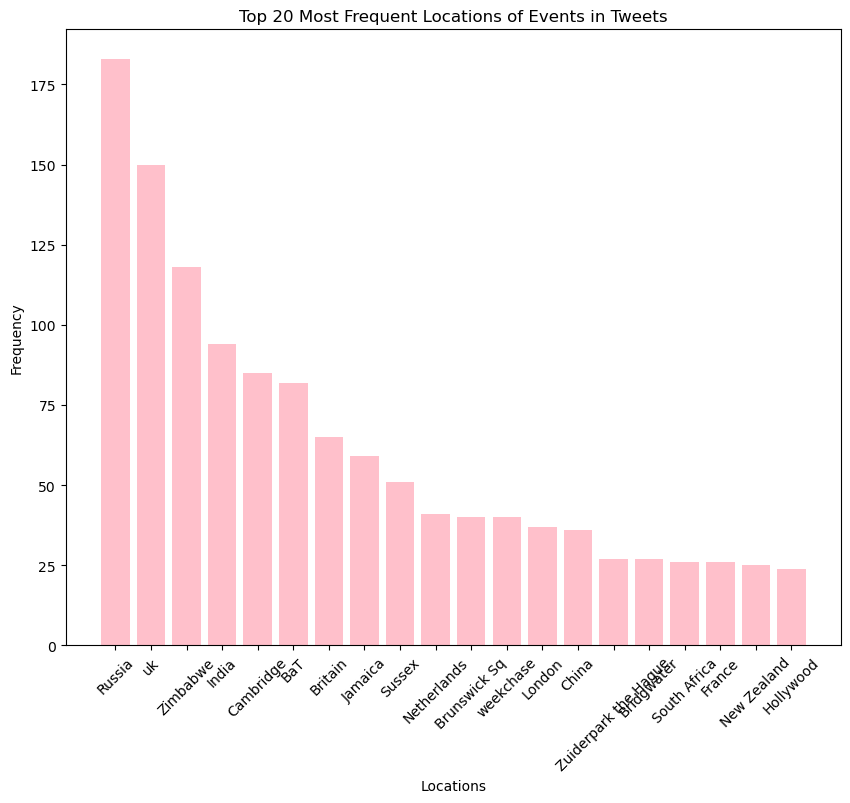

In [139]:
# Unpack the most common locations for plotting
locations, counts = zip(*most_common_locations)

# Create a bar chart
plt.figure(figsize=(10, 8))
plt.bar(locations, counts, color='pink')
plt.xlabel('Locations')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Locations of Events in Tweets')
plt.xticks(rotation=45)
plt.show()

## Location for News

In [101]:
# Filter out location entities
news_location = [entity[0] for row in news_df['entities'] for entity in row if entity[1] in ['GPE', 'LOC', 'FAC']]

In [136]:
location_counts = Counter(news_location)
most_common_locations = location_counts.most_common(20)
for location, count in most_common_locations:
    print(f"{location}: {count}")

London: 10251
Los Angeles: 9908
New York City: 6316
Hollywood: 6017
uk: 5815
West Hollywood: 5588
Miami: 5416
Australia: 5225
India: 5077
nyc: 4982
California: 4542
Paris: 4494
Sydney: 4326
New York: 4014
China: 3906
Britain: 3900
Beverly Hills: 3857
Edinburgh: 3762
U.S.: 3612
Malibu: 3498


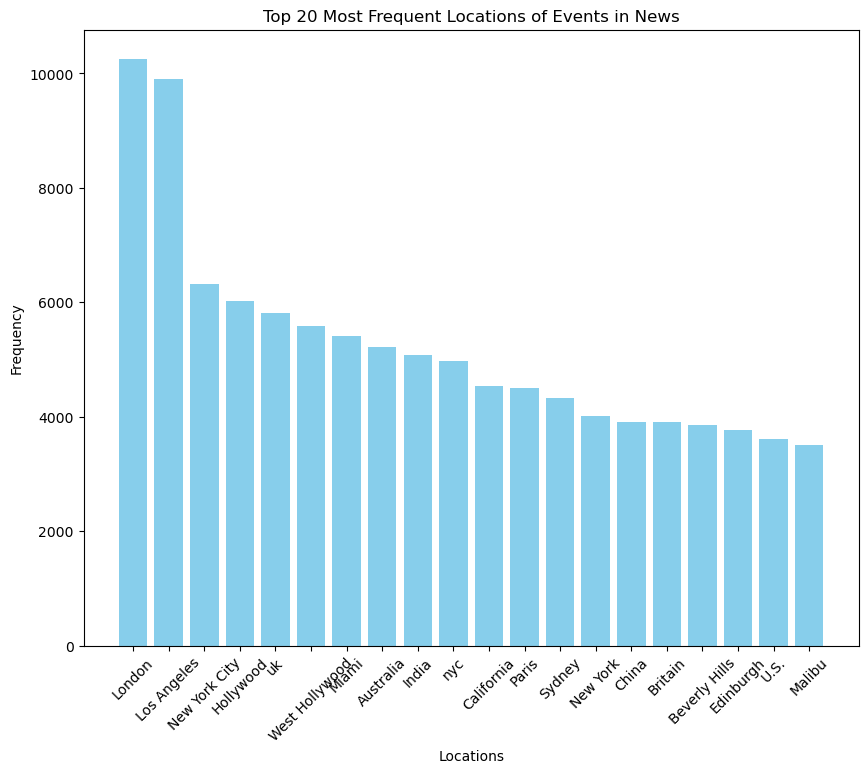

In [137]:
# Unpack the most common locations for plotting
locations, counts = zip(*most_common_locations)

# Create a bar chart
plt.figure(figsize=(10, 8))
plt.bar(locations, counts, color='skyblue')
plt.xlabel('Locations')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Locations of Events in News')
plt.xticks(rotation=45)
plt.show()

# Below showed NLTK method

## Put the summary ahead, we found the performance of NLTK method didn't overtake Spacy from the ouput. 
## And also there's no significant difference between output obtained from those with sentences segmentation and those without sentences segmentation. 
## Using NLTK to analyze on Tweets has quite similar results as to using Spacy; but the analysis output obtained from News data using NLTK is quite different from it is used with Spacy.

# Extract entities without sentence segmentation for Tweets

In [105]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

def extract_entities(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Part-of-speech tagging
    tagged = pos_tag(tokens)
    # Named entity recognition
    entities_tree = ne_chunk(tagged)
    
    # Extract entities
    entities = []
    for subtree in entities_tree:
        if hasattr(subtree, 'label'):
            entity = " ".join(word for word, tag in subtree.leaves())
            entities.append((entity, subtree.label()))
    return entities


[nltk_data] Downloading package punkt to /Users/edwinhsu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/edwinhsu/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/edwinhsu/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/edwinhsu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [26]:
# Apply the batch processing function
tweets_df['NLTK_entities'] = tweets_df['cleaned text'].parallel_apply(extract_entities)

In [27]:
tweets_df.head()

,id,lang,date,name,retweeted,text,cleaned text,entities,NLTK_entities
0,1534565117614084096,en,2022-06-08,Low Orbit Tourist 🌍📷,,"Body &amp; Assembly - Halewood - United Kingdom\n🌍53.3504,-2.8352296,402m\n\nHalewood Body &amp; Assembly is a Jaguar Land Rover factory in Halewood, England, and forms the major part of the Halewood complex which is shared with Ford who manufacture transmissions at the site. [Wikipedia] https://t.co/LPmCnZIaVt","body & amp ; Assembly - Halewood - United Kingdom 53.3504,-2.8352296,402 m Halewood Body & amp ; Assembly be a Jaguar Land Rover factory in Halewood , England , and form the major part of the Halewood complex which be share with Ford who manufacture transmission at the site . [ wikipedia ]","[(body & amp, ORG), (Assembly - Halewood - United Kingdom, ORG), (53.3504,-2.8352296,402 m, QUANTITY), (Halewood Body & amp, ORG), (Assembly, ORG), (Jaguar Land Rover, ORG), (Halewood, GPE), (England, GPE), (Halewood, GPE), (Ford, ORG)]","[(Assembly, ORGANIZATION), (Halewood, GPE), (United, GPE), (Halewood Body, PERSON), (Jaguar Land, ORGANIZATION), (Halewood, GPE), (England, GPE), (Halewood, ORGANIZATION)]"
1,1534565743429394439,en,2022-06-08,CompleteCar.ie,RT,"Land Rover Ireland has announced that the new Range Rover Sport starts at €114,150, now on @completecar:\n\nhttps://t.co/TjGUkL3FYr https://t.co/QdVaEiJkjO","Land Rover Ireland have announce that the new Range Rover Sport start at € 114,150 , now on :","[(Land Rover Ireland, ORG), (Range Rover Sport, ORG), (114,150, MONEY)]","[(Land, GPE), (Rover Ireland, PERSON), (Range Rover Sport, PERSON)]"
2,1529341557580652545,en,2022-05-25,Exmoor Trim,,New Land Rover Range Rover Hits Top Speed With Ease On Autobahn\n\nhttps://t.co/19QOgAIu3v,New Land Rover Range Rover Hits Top Speed with ease on Autobahn,"[(New Land Rover Range Rover Hits Top Speed, ORG), (Autobahn, FAC)]","[(New Land, GPE), (Range Rover Hits Top Speed, PERSON)]"
3,1542790343535755264,en,2022-07-01,Land Rover UK,,"@BeckyWatts1 Hi, thank you for your post. I am sorry to learn of your retailer experience, however when order slots are available they will be presented to the retailer, and it is at their discretion which vehicles they submit. Please continue to liaise with them. Thanks, Dan - Land Rover UK","hi , thank you for your post . I be sorry to learn of your retailer experience , however when order slot be available they will be present to the retailer , and it be at their discretion which vehicle they submit . please continue to liaise with they . thank , Dan - Land Rover uk","[(Dan - Land, PERSON)]","[(Dan, GPE), (Land, GPE)]"
4,1516732103370493954,en,2022-04-20,Sussexes❤️👑🐼🌸,,@cofvefe917 @Mackingday No this was during the Land Rover driving challenge.,no this be during the Land Rover drive challenge .,"[(Land Rover, ORG)]","[(Land Rover, ORGANIZATION)]"


In [164]:
# Flatten the entities list, filter by "ORG", and count occurrences
org_entities = [entity for sublist in tweets_df['NLTK_entities'] for entity in sublist if entity[1] == 'ORGANIZATION']
org_text_counts = Counter([entity[0] for entity in org_entities])

# Get the top 20 most common "ORG" entities
top_20_org_entities = org_text_counts.most_common(20)

print(top_20_org_entities)

[('Land Rover', 1465), ('Land', 762), ('Mercedes', 338), ('Land Rover Discovery', 337), ('eBay', 308), ('General Motors', 299), ('Duke', 191), ('Duchess', 174), ('Jaguar Land Rover', 132), ('Jaguar Land', 114), ('Land Rover Defender', 100), ('BaT', 82), ('Queen', 78), ('Paracetamol', 64), ('BR19', 63), ('Clent Hills Vets', 62), ('Rover', 59), ('Invictus Games', 55), ('Ford', 47), ('Invictus', 46)]


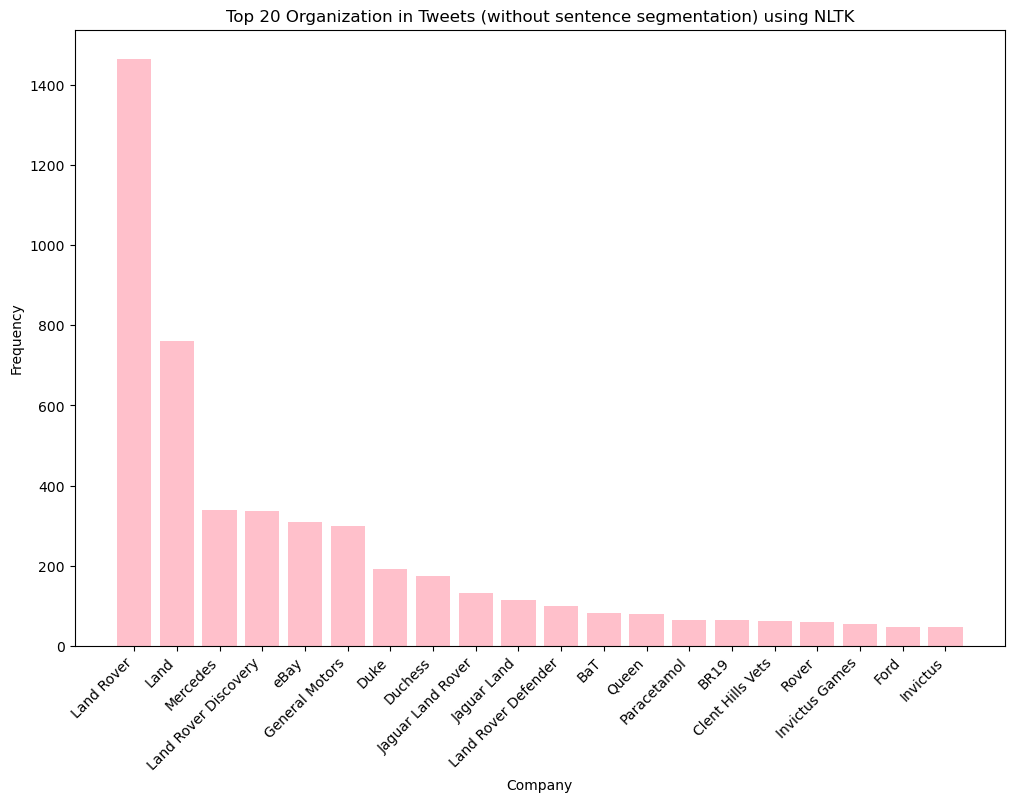

In [165]:
# Assuming entity_names and counts have been defined as before
entity_names, counts = zip(*top_20_org_entities)  # Unzipping names and counts

plt.figure(figsize=(12, 8))  # Adjust figure size as needed for vertical orientation
plt.bar(entity_names, counts, color="pink")  # Create a vertical bar chart
plt.ylabel('Frequency')  # Y-axis label now represents frequency
plt.xlabel('Company')  # X-axis label now represents company names
plt.title('Top 20 Organization in Tweets (without sentence segmentation) using NLTK')  # Title of the plot
plt.xticks(rotation=45, ha="right")  # Rotate company names for better readability
plt.show()

# Extract entities without sentence segmentation for News

In [106]:
# Apply the batch processing function
news_df['NLTK_entities'] = news_df['cleaned text'].parallel_apply(extract_entities)

In [166]:
# Flatten the entities list, filter by "ORG", and count occurrences
org_entities = [entity for sublist in news_df['NLTK_entities'] for entity in sublist if entity[1] == 'ORGANIZATION']
org_text_counts = Counter([entity[0] for entity in org_entities])

# Get the top 20 most common "ORG" entities
top_20_org_entities = org_text_counts.most_common(20)

print(top_20_org_entities)

[('MailOnline', 8826), ('Duke', 4931), ('House', 3929), ('Duchess', 3808), ('Princess Diana', 3616), ('Queen', 3577), ('Mercedes', 2726), ('Kate', 2700), ('Prince Philip', 2698), ('Conditions', 2346), ('Prince Harry', 2263), ('Kate Middleton', 2250), ('Daily Mail', 2145), ('RomeoAston', 2109), ('Princess', 2071), ('Astroworld', 2057), ('UsContact', 1962), ('GuideFor', 1962), ('Autopath Technologies Inc.', 1962), ('TopMore', 1961)]


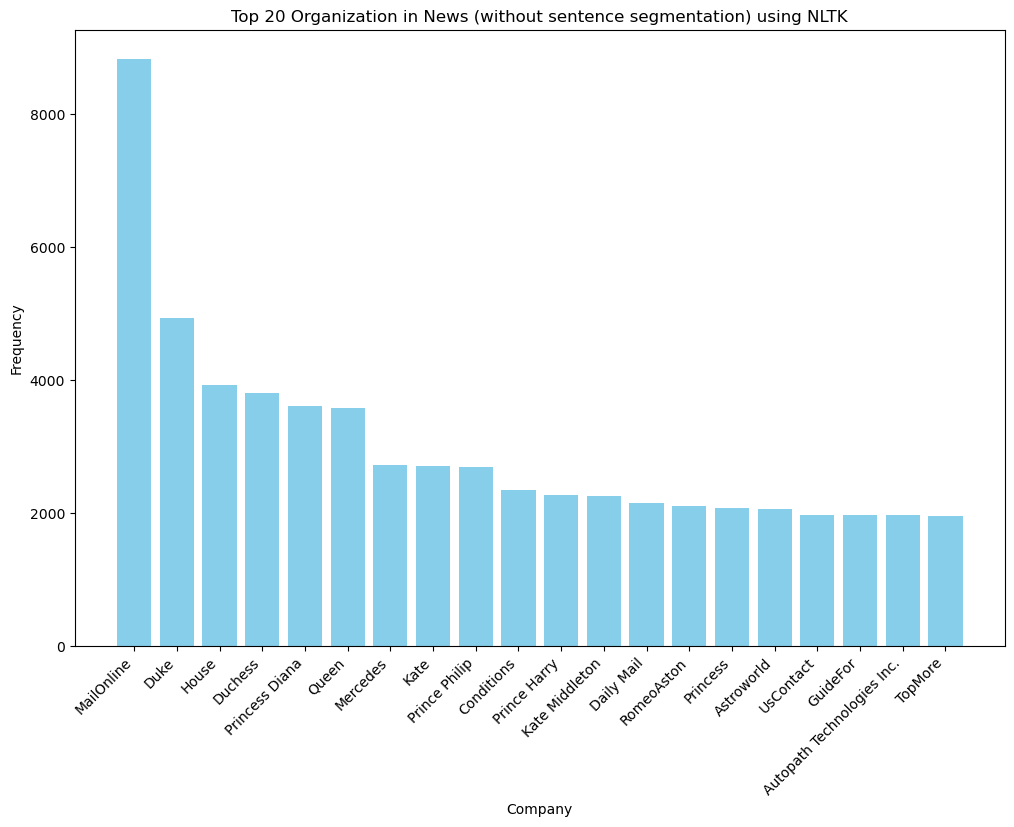

In [167]:
# Assuming entity_names and counts have been defined as before
entity_names, counts = zip(*top_20_org_entities)  # Unzipping names and counts

plt.figure(figsize=(12, 8))  # Adjust figure size as needed for vertical orientation
plt.bar(entity_names, counts, color="skyblue")  # Create a vertical bar chart
plt.ylabel('Frequency')  # Y-axis label now represents frequency
plt.xlabel('Company')  # X-axis label now represents company names
plt.title('Top 20 Organization in News (without sentence segmentation) using NLTK')  # Title of the plot
plt.xticks(rotation=45, ha="right")  # Rotate company names for better readability
plt.show()

# For News' title

In [111]:
news_df['NLTK_title_entities'] = news_df['cleaned title'].parallel_apply(extract_entities)

In [168]:
# Flatten the entities list, filter by "ORG", and count occurrences
org_entities = [entity for sublist in news_df['NLTK_title_entities'] for entity in sublist if entity[1] == 'ORGANIZATION']
org_text_counts = Counter([entity[0] for entity in org_entities])

# Get the top 20 most common "ORG" entities
top_20_org_entities = org_text_counts.most_common(20)

print(top_20_org_entities)

[('Daily Mail Online', 421), ('AutoSpies Auto News', 145), ('Mercedes', 103), ('CoventryLive', 97), ('NewsBreak', 82), ('Record', 54), ('Automotive News', 46), ('Hindu', 42), ('News', 37), ('Fast Lane', 34), ('CarWale', 29), ('Prince Philip', 29), ('Business', 26), ('Philip', 25), ('Star News', 23), ('EVs', 23), ('Land', 22), ('Navigation', 21), ('Land Rover', 19), ('Shropshire Star', 18)]


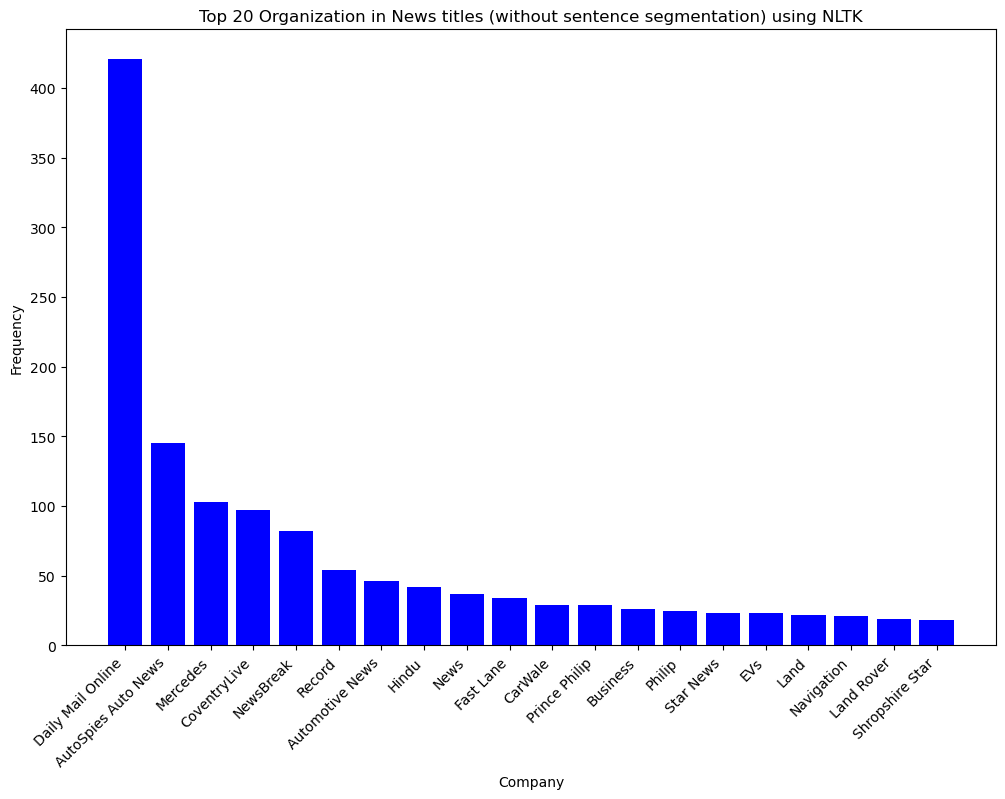

In [169]:
# Assuming entity_names and counts have been defined as before
entity_names, counts = zip(*top_20_org_entities)  # Unzipping names and counts

plt.figure(figsize=(12, 8))  # Adjust figure size as needed for vertical orientation
plt.bar(entity_names, counts, color="blue")  # Create a vertical bar chart
plt.ylabel('Frequency')  # Y-axis label now represents frequency
plt.xlabel('Company')  # X-axis label now represents company names
plt.title('Top 20 Organization in News titles (without sentence segmentation) using NLTK')  # Title of the plot
plt.xticks(rotation=45, ha="right")  # Rotate company names for better readability
plt.show()

# Extract entities with sentence segmentation for Tweets

In [31]:
from nltk.tokenize import sent_tokenize

def extract_entities_with_sentences(text):
    entities = []
    # Sentence segmentation
    sentences = sent_tokenize(text)
    for sentence in sentences:
        # Tokenize the sentence into words
        tokens = word_tokenize(sentence)
        # Part-of-speech tagging
        tagged = pos_tag(tokens)
        # Named entity recognition
        entities_tree = ne_chunk(tagged)
        
        for subtree in entities_tree:
            if hasattr(subtree, 'label'):
                entity = " ".join(word for word, tag in subtree.leaves())
                entities.append((entity, subtree.label()))
    return entities


In [32]:
tweets_df['NLTK_seg_entities'] = tweets_df['cleaned text'].parallel_apply(extract_entities_with_sentences)

In [170]:
# Flatten the entities list, filter by "ORG", and count occurrences
org_seg_entities = [entity for sublist in tweets_df['NLTK_seg_entities'] for entity in sublist if entity[1] == 'ORGANIZATION']
org_seg_text_counts = Counter([entity[0] for entity in org_seg_entities])

# Get the top 20 most common "ORG" entities
top_20_org_seg_entities = org_seg_text_counts.most_common(20)
print(top_20_org_seg_entities)

[('Land Rover', 1468), ('Land', 779), ('Land Rover Discovery', 337), ('Mercedes', 326), ('eBay', 308), ('General Motors', 299), ('Duke', 191), ('Duchess', 174), ('Jaguar Land Rover', 132), ('Jaguar Land', 114), ('Land Rover Defender', 100), ('Rover', 91), ('BaT', 82), ('Queen', 78), ('Paracetamol', 64), ('BR19', 63), ('Clent Hills Vets', 62), ('Invictus Games', 55), ('Ford', 47), ('Invictus', 46)]


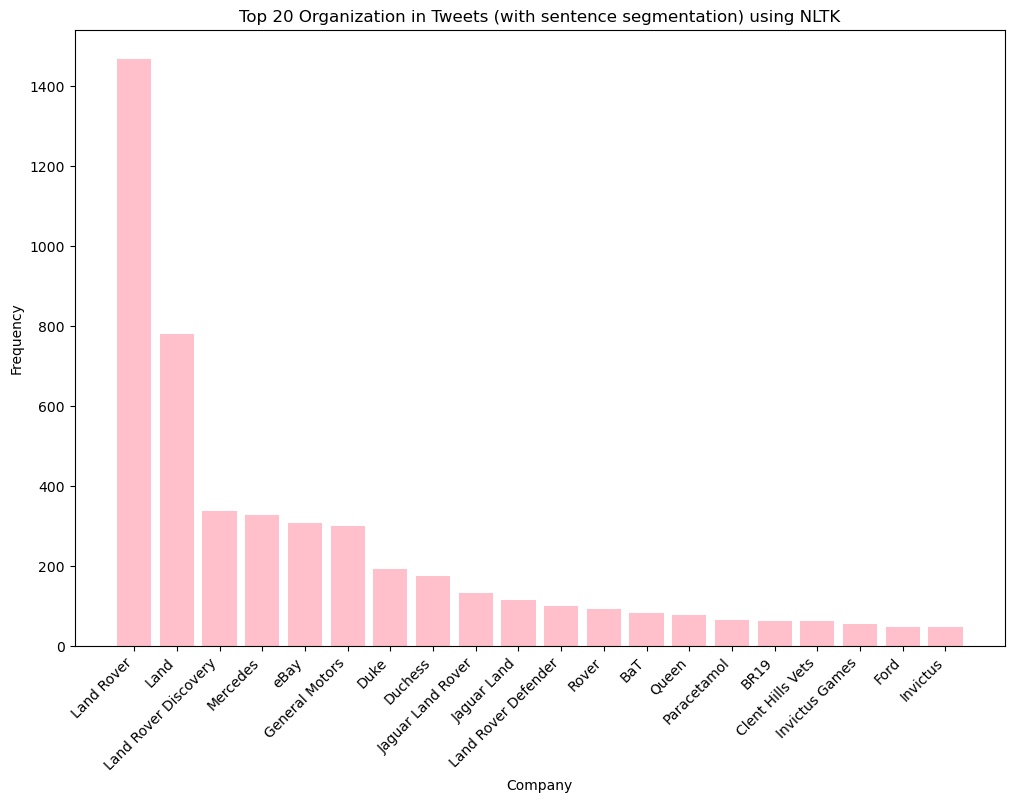

In [171]:
# Assuming entity_names and counts have been defined as before
entity_names, counts = zip(*top_20_org_seg_entities)  # Unzipping names and counts

plt.figure(figsize=(12, 8))  # Adjust figure size as needed for vertical orientation
plt.bar(entity_names, counts, color="pink")  # Create a vertical bar chart
plt.ylabel('Frequency')  # Y-axis label now represents frequency
plt.xlabel('Company')  # X-axis label now represents company names
plt.title('Top 20 Organization in Tweets (with sentence segmentation) using NLTK')  # Title of the plot
plt.xticks(rotation=45, ha="right")  # Rotate company names for better readability
plt.show()

# Extract entities with sentence segmentation for News

In [116]:
news_df['NLTK_seg_entities'] = news_df['cleaned text'].parallel_apply(extract_entities_with_sentences)

In [172]:
# Flatten the entities list, filter by "ORG", and count occurrences
org_seg_entities = [entity for sublist in news_df['NLTK_seg_entities'] for entity in sublist if entity[1] == 'ORGANIZATION']
org_seg_text_counts = Counter([entity[0] for entity in org_seg_entities])

# Get the top 20 most common "ORG" entities
top_20_org_seg_entities = org_seg_text_counts.most_common(20)
print(top_20_org_seg_entities)

[('MailOnline', 8816), ('Duke', 4933), ('House', 4050), ('Duchess', 3808), ('Queen', 3578), ('Princess Diana', 3541), ('Prince Philip', 2698), ('Kate', 2677), ('Mercedes', 2665), ('Princess', 2544), ('Conditions', 2346), ('Prince Harry', 2263), ('Kate Middleton', 2169), ('Daily Mail', 2145), ('RomeoAston', 2109), ('Astroworld', 2057), ('UsContact', 1963), ('GuideFor', 1962), ('Autopath Technologies Inc.', 1962), ('PolicyTerms', 1962)]


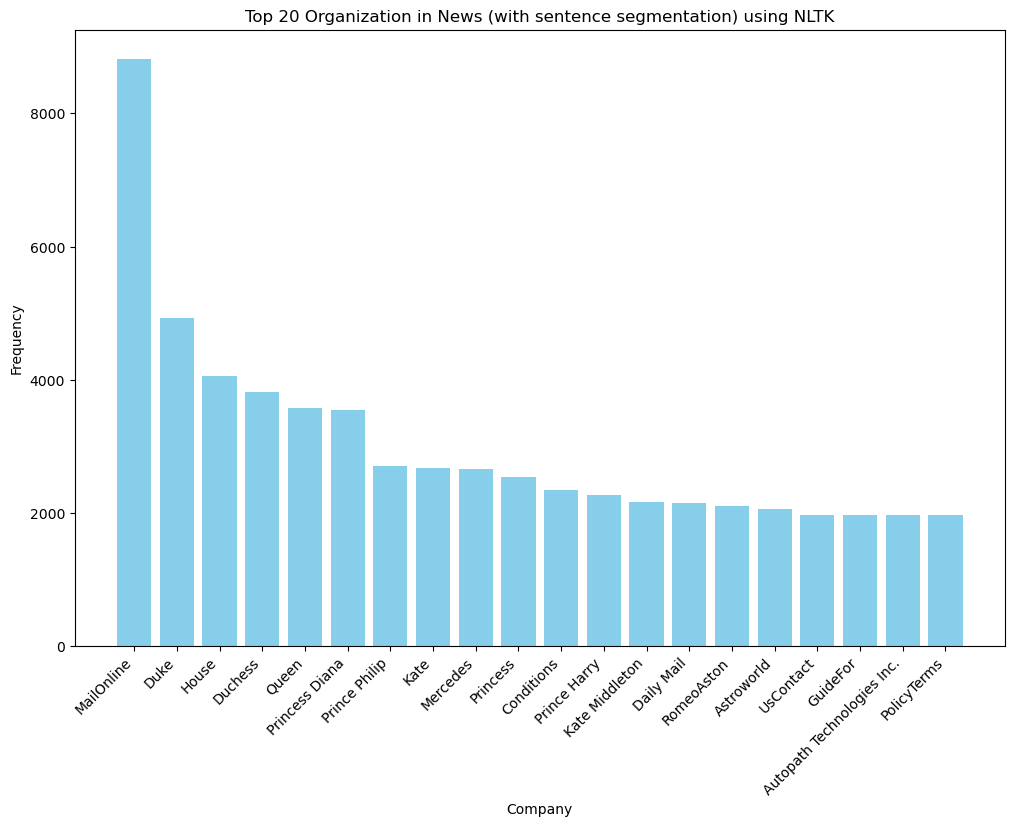

In [173]:
# Assuming entity_names and counts have been defined as before
entity_names, counts = zip(*top_20_org_seg_entities)  # Unzipping names and counts

plt.figure(figsize=(12, 8))  # Adjust figure size as needed for vertical orientation
plt.bar(entity_names, counts, color="skyblue")  # Create a vertical bar chart
plt.ylabel('Frequency')  # Y-axis label now represents frequency
plt.xlabel('Company')  # X-axis label now represents company names
plt.title('Top 20 Organization in News (with sentence segmentation) using NLTK')  # Title of the plot
plt.xticks(rotation=45, ha="right")  # Rotate company names for better readability
plt.show()

# For News' title

In [119]:
news_df['NLTK_seg_title_entities'] = news_df['cleaned title'].parallel_apply(extract_entities_with_sentences)

In [174]:
# Flatten the entities list, filter by "ORG", and count occurrences
org_seg_entities = [entity for sublist in news_df['NLTK_seg_title_entities'] for entity in sublist if entity[1] == 'ORGANIZATION']
org_seg_text_counts = Counter([entity[0] for entity in org_seg_entities])

# Get the top 20 most common "ORG" entities
top_20_org_seg_entities = org_seg_text_counts.most_common(20)
print(top_20_org_seg_entities)

[('Daily Mail Online', 397), ('AutoSpies Auto News', 145), ('Mercedes', 102), ('CoventryLive', 97), ('NewsBreak', 82), ('Record', 54), ('Automotive News', 46), ('Hindu', 42), ('News', 36), ('Fast Lane', 34), ('CarWale', 29), ('Prince Philip', 29), ('Business', 26), ('Philip', 25), ('Star News', 24), ('EVs', 23), ('Land', 22), ('Navigation', 21), ('Land Rover', 19), ('Shropshire Star', 18)]


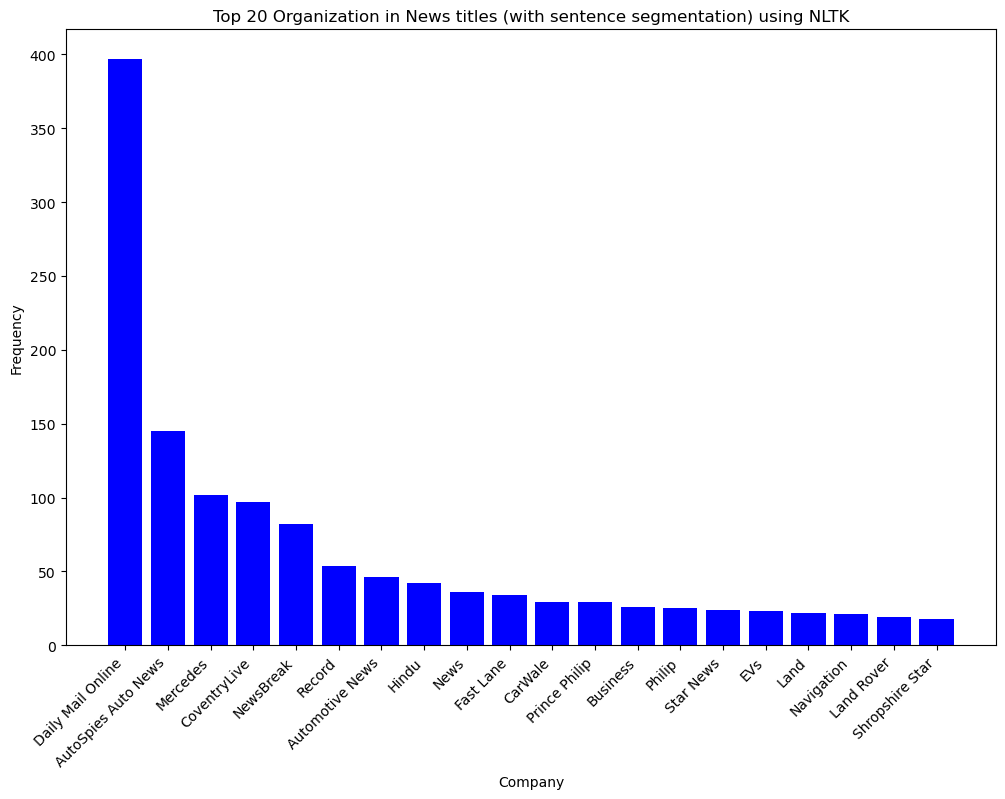

In [175]:
# Assuming entity_names and counts have been defined as before
entity_names, counts = zip(*top_20_org_seg_entities)  # Unzipping names and counts

plt.figure(figsize=(12, 8))  # Adjust figure size as needed for vertical orientation
plt.bar(entity_names, counts, color="blue")  # Create a vertical bar chart
plt.ylabel('Frequency')  # Y-axis label now represents frequency
plt.xlabel('Company')  # X-axis label now represents company names
plt.title('Top 20 Organization in News titles (with sentence segmentation) using NLTK')  # Title of the plot
plt.xticks(rotation=45, ha="right")  # Rotate company names for better readability
plt.show()